## Imports

In [2]:
# Standard \ I/O
import os
from pathlib import Path

# Numerics \ data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
import seaborn as sns

# Neuro \ surfaces \ parcellations
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from enigmatoolbox.utils.parcellation import parcel_to_surface
from netneurotools import datasets as nntdata
from brainspace.datasets import load_parcellation

# Stats \ annotations
from statannotations.Annotator import Annotator
from scipy.stats import (
    ttest_ind,
    mannwhitneyu,
    spearmanr,
    permutation_test,
    chi2_contingency,
    chi2
)
from scipy.optimize import linear_sum_assignment
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

#  ML \ clustering \ metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.manifold import MDS

# Utils
from itertools import groupby

# Embeddings
import umap

# Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Utils

In [3]:
def symmetrize(A, mode="mean"):
    A = np.asarray(A, float)
    if mode == "mean":
        S = 0.5 * (A + A.T)
    elif mode == "max":
        S = np.maximum(A, A.T)
    elif mode == "min":
        S = np.minimum(A, A.T)
    else:
        raise ValueError("mode must be one of: 'mean', 'max', 'min'")
    np.fill_diagonal(S, 0.0)
    return S


def symmetry_degree(A):
    A = np.asarray(A, float)
    diff = np.linalg.norm(A - A.T)
    tot = np.linalg.norm(A)
    return 1.0 if tot == 0 else 1.0 - diff / tot


def upper_flat(A):
    iu = np.triu_indices_from(A, k=1)
    return A[iu]


def knn_sets(D, k=5):
    out = []
    for i in range(D.shape[0]):
        idx = np.argsort(D[i])
        out.append(set(idx[1:k+1]))
    return out


def inter_cluster_mean_distance(D, labels):
    labs = np.unique(labels)
    if len(labs) < 2:
        return np.nan
    i0 = np.where(labels == labs[0])[0]
    i1 = np.where(labels == labs[1])[0]
    return float(D[np.ix_(i0, i1)].mean())
    
    
def compute_pac(C, low=0.1, high=0.9):
    '''
    Compute Proportion of Ambiguous Clustering (PAC)
    '''
    mask_offdiag = ~np.eye(C.shape[0], dtype=bool)
    C_off = C[mask_offdiag]
    return np.mean((C_off > low) & (C_off < high))


def cliff_delta(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    n = len(a)
    m = len(b)
    diff = np.subtract.outer(a, b)
    gt = int(np.sum(diff > 0))
    lt = int(np.sum(diff < 0))
    return (gt - lt) / (n * m)

## Plotting

In [4]:
def plot_matrices_to_axes_no_cbar(matrices, axes, network_labels, network_names, titles=None, vminvmax=[-1, 1], cmap='RdBu_r', sort=True):
    network_labels = np.array(network_labels)
    tick_positions = []
    label_positions = []    
    tick_labels = []

    if sort:
        tick_positions = []
        label_positions = []
        tick_labels = []

        _, sorted_labels = np.unique(network_labels, return_inverse=True)
        sorted_indices = np.argsort(sorted_labels)
        prev_label = sorted_labels[sorted_indices[0]]
        start_idx = 0
        sorted_seq = sorted_labels[sorted_indices]

        for i, label in enumerate(sorted_seq):
            is_last = (i == len(sorted_seq) - 1)
            if label != prev_label or is_last:
                end_idx = i if label != prev_label else i + 1
                tick_positions.append(end_idx)
                center = (start_idx + end_idx) / 2 + 1.2
                label_positions.append(center)
                tick_labels.append(network_names[prev_label])
                start_idx = i
                prev_label = label
    else:
        sorted_indices = np.arange(len(network_labels))

    for i, (matrix, ax) in enumerate(zip(matrices, axes)):
        mat_to_plot = matrix[np.ix_(sorted_indices, sorted_indices)] if sort else matrix
        sns.heatmap(mat_to_plot, ax=ax, cmap=cmap, center=0,
                    vmin=vminvmax[0], vmax=vminvmax[1], square=True,
                    xticklabels=False, yticklabels=False,
                    cbar=False)

        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)

        for pos, label in zip(label_positions, tick_labels):
            ax.text(pos + 0.5, ax.get_ylim()[0] + 1.5, label, ha='center', va='top', rotation=90)
            ax.text(ax.get_xlim()[0] - 1.5, pos, label, ha='right', va='center')

        ax.tick_params(axis='both', length=2)

        if titles and i < len(titles):
            ax.set_title(titles[i])

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)


def add_cov_ellipse(ax, x, y, color, alpha=0.18, lw=1.2):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    if x.size < 3:
        return
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]
    r2 = chi2.ppf(0.95, df=2)
    w, h = 2 * np.sqrt(np.maximum(vals, 0) * r2)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    center = (x.mean(), y.mean())
    ax.add_patch(Ellipse(center, width=w, height=h, angle=angle,
                         facecolor=color, edgecolor=color, alpha=alpha, lw=lw))
    ax.scatter(*center, s=80, marker="*", color=color,
               edgecolors="black", linewidths=0.6, zorder=5)
    
    
def p_text(p):
    if p < 0.001:
        return r"$p < 0.001$ ***"
    elif p < 0.01:
        return r"$p < 0.01$ **"
    elif p < 0.05:
        return r"$p < 0.05$ *"
    else:
        return r"$p \geq 0.05$"


def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''


# Stile settings
plt.style.use("tableau-colorblind10")

plt.rcParams["figure.autolayout"] = True
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["cmr10"],  # LaTeX-like font
    "mathtext.fontset": "cm",  # Computer Modern math font
    "mathtext.default": "regular",  # Allows Greek letters without issues
    "axes.formatter.use_mathtext": True,
    "text.usetex": True  # Keep False unless using full LaTeX engine
})

# Available styles
print(plt.style.available)

# Remove to and right axis from plots
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Data

In [5]:
DATA_DIR = Path(r"C:\Users\lucat\Desktop\PNC\Codes\HMM_OT\data")
FIG_DIR  = Path(r"C:\Users\lucat\Desktop\PNC\Codes\HMM_OT\figures")

if not DATA_DIR.exists():
    DATA_DIR = Path("../data")

if not FIG_DIR.exists():
    FIG_DIR = Path("../figures")

DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load data
network_labels = np.load(DATA_DIR / "network_labels.npy")  
network_names = np.load(DATA_DIR / "network_names.npy")  
fcs_all = np.load(DATA_DIR / "fcs_all.npy")  # shape: (subjects, rois, rois) - subject order as df_sel and df_hmm)
means_orig = np.load(DATA_DIR / "means_orig.npy")  # means of hmm states on parcel space
fcs_orig = np.load(DATA_DIR / "fcs_orig.npy")  # FC of states back-projected on parcel space 
cost_dir = np.load(DATA_DIR / "ot_cost_matrix.npy")  # cost matrix (subjects x subjects)

df_hmm = pd.read_csv(DATA_DIR / "df_hmm_metrics.csv")  #  hmm metrics per subject and state
df_sel = pd.read_csv(DATA_DIR / "df_sel.csv")  # demographic and clinical variables 
df_hmm_corr = pd.read_csv(DATA_DIR / "df_hmm_corr.csv")  # correlations between state metrics and clinical variables
df_clust_diff = pd.read_csv(DATA_DIR / "cluster_clin_diff.csv")  # statistical differences between the two MS clusters
df_ms_ot_clusters = pd.read_csv(DATA_DIR / "ms_df_ot_clusters.csv")  # all inmformation about MS (clinical, demographic, clusters, MDS)

# Rename states (0 -> 1, 1 -> 2, etc.) and organize datasets
df_hmm["State"] = df_hmm["State"].str.replace("State", "State ", regex=False)
df_hmm["State"] = df_hmm["State"].str.replace(r"State (\d+)", lambda m: f"State {int(m.group(1))+1}", regex=True)
df_hmm_corr["State"] = df_hmm_corr["State"].str.replace("State", "State ", regex=False)
df_hmm_corr["State"] = df_hmm_corr["State"].str.replace(r"State (\d+)", lambda m: f"State {int(m.group(1))+1}", regex=True)
df_sel.rename(columns={"group": "Group"}, inplace=True)
df_ms_ot_clusters.rename(columns={'group': 'Group'}, inplace=True)

## Robustness of OT-based clustering to matrix symmetrization 

Silhouette and k selection
Mode mean: k=2 sil=0.6943, k=3 sil=0.6105, k=4 sil=0.5594
Mode max : k=2 sil=0.6936, k=3 sil=0.6050, k=4 sil=0.5570
Mode min : k=2 sil=0.6938, k=3 sil=0.6156, k=4 sil=0.5527
Best k (mean) = 2 (sil=0.6943)

Cluster agreement vs mean (using k = 2)
max vs mean: ARI=1.000, changed=0/122
min vs mean: ARI=1.000, changed=0/122

OT cost asymmetry (MS)
symmetry_degree = 0.689

Global similarity (upper-tri corr)
corr(mean,max) = 0.991267
corr(mean,min) = 0.986815
corr(max,min)  = 0.956854

Local changes (max relative diff)
max relative diff (max vs mean) = 0.634254 (of course same for min)

5-NN stability
fraction identical 5-NN (mean vs max) = 0.606557
fraction identical 5-NN (mean vs min) = 0.418033

Inter-cluster mean distance (k=2)
mean: inter-cluster mean distance = 2.97445
max : inter-cluster mean distance = 3.37771
min : inter-cluster mean distance = 2.57119


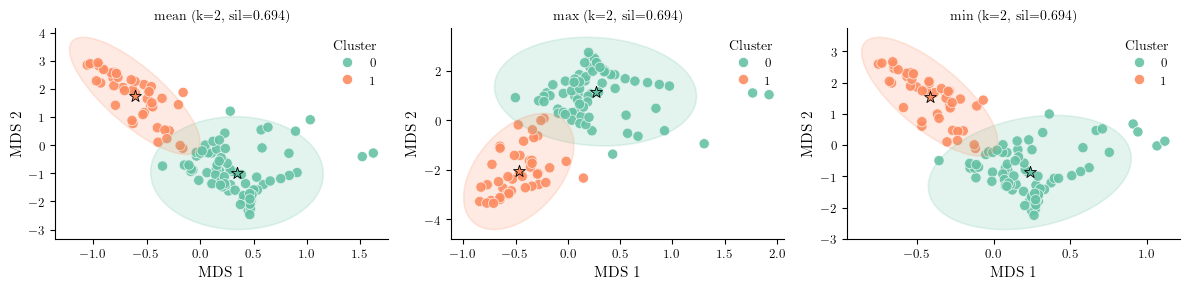

In [ ]:
 # Config
MODES = ["mean", "max", "min"]  # type of symmetrizations
K_RANGE = range(2, 5)
LINKAGE = "average"
NN_K = 5

# OT cost matrix (of MS)
C_full = np.asarray(cost_dir, float).copy()
np.fill_diagonal(C_full, 0.0)  # ensure zero self-diagonal

group_col = "Group" if "Group" in df_sel.columns else "group"
ms_idx = np.where(df_sel[group_col].astype(str).values == "MS")[0]

# Silhouette + best k + labels + embedding
rows = []
results = {}

for mode in MODES:
    C_ms = symmetrize(C_full, mode=mode)[np.ix_(ms_idx, ms_idx)]

    best = {"k": None, "sil": -np.inf, "labels": None}
    for k in K_RANGE:
        model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage=LINKAGE)
        lab = model.fit_predict(C_ms)
        sil = silhouette_score(C_ms, lab, metric="precomputed")
        rows.append({"mode": mode, "k": k, "sil": sil})
        if sil > best["sil"]:
            best.update({"k": k, "sil": sil, "labels": lab})
    emb = MDS(dissimilarity="precomputed", random_state=26).fit_transform(C_ms)

    ms_df = df_sel.iloc[ms_idx].copy()
    ms_df["OT_cluster"] = best["labels"].astype(int)
    ms_df["OT_dim1"] = emb[:, 0]
    ms_df["OT_dim2"] = emb[:, 1]

    results[mode] = {"C_ms": C_ms, "best": best, "ms_df": ms_df}

df_sil = pd.DataFrame(rows).sort_values(["mode", "k"]).reset_index(drop=True)

# Prints checks summary
print("Silhouette and k selection")
for mode in MODES:
    d = df_sil.query("mode == @mode")
    line = ", ".join([f"k={r.k} sil={r.sil:.4f}" for r in d.itertuples(index=False)])
    print(f"Mode {mode:<4}: {line}")

ref_k = results["mean"]["best"]["k"]
ref = results["mean"]["best"]["labels"]
print(f"Best k (mean) = {ref_k} (sil={results['mean']['best']['sil']:.4f})")

print("\nCluster agreement vs mean (using k = 2)")
for mode in ["max", "min"]:
    C_ms = results[mode]["C_ms"]
    lab = AgglomerativeClustering(n_clusters=ref_k, metric="precomputed", linkage=LINKAGE).fit_predict(C_ms)
    ari = adjusted_rand_score(ref, lab)
    changed = min(np.sum(lab != ref), np.sum((1 - lab) != ref)) if len(np.unique(lab)) == 2 else np.sum(lab != ref)
    print(f"{mode:<3} vs mean: ARI={ari:.3f}, changed={changed}/{len(ref)}")

C_ms_raw = C_full[np.ix_(ms_idx, ms_idx)]
print("\nOT cost asymmetry (MS)")
print(f"symmetry_degree = {symmetry_degree(C_ms_raw):.3f}")

print("\nGlobal similarity (upper-tri corr)")
v_mean = upper_flat(results["mean"]["C_ms"])
v_max  = upper_flat(results["max"]["C_ms"])
v_min  = upper_flat(results["min"]["C_ms"])
print(f"corr(mean,max) = {np.corrcoef(v_mean, v_max)[0,1]:.6f}")
print(f"corr(mean,min) = {np.corrcoef(v_mean, v_min)[0,1]:.6f}")
print(f"corr(max,min)  = {np.corrcoef(v_max,  v_min)[0,1]:.6f}")

print("\nLocal changes (max relative diff)")
rel_max_mean = np.max(np.abs(v_max - v_mean) / (np.abs(v_mean) + 1e-12))
print(f"max relative diff (max vs mean) = {rel_max_mean:.6f} (of course same for min)")

print(f"\n{NN_K}-NN stability")
nn_mean = knn_sets(results["mean"]["C_ms"], k=NN_K)
nn_max  = knn_sets(results["max"]["C_ms"],  k=NN_K)
nn_min  = knn_sets(results["min"]["C_ms"],  k=NN_K)
frac_mean_max = np.mean([nn_mean[i] == nn_max[i] for i in range(len(nn_mean))])
frac_mean_min = np.mean([nn_mean[i] == nn_min[i] for i in range(len(nn_mean))])
print(f"fraction identical {NN_K}-NN (mean vs max) = {frac_mean_max:.6f}")
print(f"fraction identical {NN_K}-NN (mean vs min) = {frac_mean_min:.6f}")

print(f"\nInter-cluster mean distance (k={ref_k})")
for mode in MODES:
    C_ms = results[mode]["C_ms"]
    lab = AgglomerativeClustering(n_clusters=ref_k, metric="precomputed", linkage=LINKAGE).fit_predict(C_ms)
    d_inter = inter_cluster_mean_distance(C_ms, lab)
    print(f"{mode:<4}: inter-cluster mean distance = {d_inter:.5f}")

# Plot clustering
fig, axes = plt.subplots(1, len(MODES), figsize=(4 * len(MODES), 3))

for ax, mode in zip(np.atleast_1d(axes), MODES):
    ms_df = results[mode]["ms_df"]
    best = results[mode]["best"]

    cluster_levels = sorted(ms_df["OT_cluster"].unique())
    palette = dict(zip(cluster_levels, sns.color_palette("Set2", n_colors=len(cluster_levels))))

    sns.scatterplot(
        data=ms_df,
        x="OT_dim1", y="OT_dim2",
        hue="OT_cluster", hue_order=cluster_levels,
        palette=palette,
        edgecolor="white", linewidth=0.6,
        s=55, alpha=0.9,
        ax=ax
    )

    for lab in cluster_levels:
        d = ms_df.query("OT_cluster == @lab")
        add_cov_ellipse(ax, d["OT_dim1"].values, d["OT_dim2"].values, color=palette[lab])

    ax.set_xlabel("MDS 1")
    ax.set_ylabel("MDS 2")
    ax.set_title(f"{mode} (k={best['k']}, sil={best['sil']:.3f})")
    ax.legend(frameon=False, title="Cluster", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Correlation of MDS dimensions with HMM metrics
# Select MDS dimensions and clusters from previous analyses (mean symmetrization)
ms_df = results["mean"]["ms_df"].rename(columns={"OT_dim1": "MDS1", "OT_dim2": "MDS2"})
cluster_col = "OT_cluster"
id_col = "participant_id"

df_merged = df_hmm[df_hmm[group_col].astype(str).eq("MS")].merge(
    ms_df[[id_col, "MDS1", "MDS2", cluster_col]],
    on=id_col, how="inner"
)

mds_dims = [c for c in ["MDS1", "MDS2"] if c in df_merged.columns]
states_all = sorted(df_merged["State"].unique())

state_metrics = [c for c in ["FO_soft", "Dwell"] if c in df_merged.columns]
global_metrics = [c for c in ["SwitchRate"] if c in df_merged.columns]

# compute correlations and p-values
rows = []

# state-level metrics
for state in states_all:
    d0 = df_merged[df_merged["State"] == state]
    for metric in state_metrics:
        for mds_var in mds_dims:
            x = d0[metric]
            y = d0[mds_var]
            mask = x.notna() & y.notna()
            rho, p = spearmanr(x[mask], y[mask])
            rows.append((state, metric, mds_var, float(rho), float(p)))

# global metrics i.e. switching rate (one value per subject)
if len(global_metrics) > 0:
    dG = df_merged.drop_duplicates(subset=[id_col])  # keeps one row per subject
    for metric in global_metrics:
        for mds_var in mds_dims:
            x = dG[metric]
            y = dG[mds_var]
            mask = x.notna() & y.notna()
            rho, p = spearmanr(x[mask], y[mask])
            rows.append(("Global", metric, mds_var, float(rho), float(p)))

df_corr = pd.DataFrame(rows, columns=["State", "Metric", "MDS", "rho", "p"])

reject, pvals_fdr, _, _ = multipletests(df_corr["p"].values, method="fdr_bh")
df_corr["p_fdr"] = pvals_fdr
df_corr["significant"] = reject

lookup = {
    (r.State, r.Metric, r.MDS): (r.rho, r.p_fdr, r.significant)
    for r in df_corr.itertuples(index=False)
}


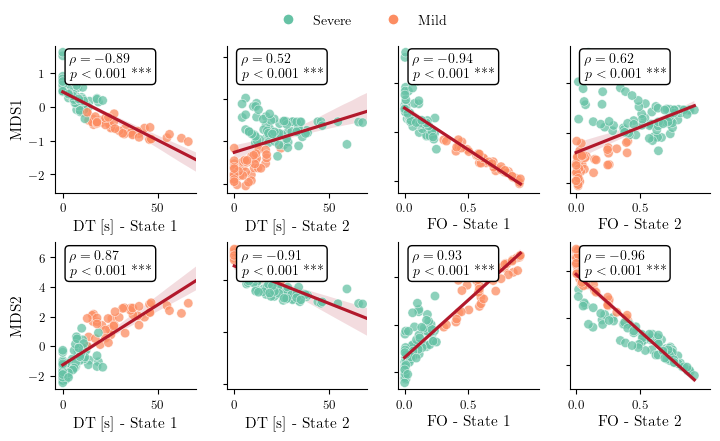

In [56]:
# rename clusters
ms_df_plot = ms_df.copy()
cluster_col = "ClusterName"
cluster_map = {0: "Severe", 1: "Mild"}
ms_df_plot[cluster_col] = ms_df_plot["OT_cluster"].map(cluster_map)

df_merged_plot = df_merged.drop(columns=[cluster_col], errors="ignore").merge(
    ms_df_plot[[id_col, cluster_col]],
    on=id_col, how="left"
)

# plot selected features
metrics_to_plot   = ["Dwell", "FO_soft"]
states_to_plot    = ["State 1", "State 2"]
mds_dims_to_plot  = ["MDS1", "MDS2"]

N_COLS   = None
FIG_W_CM = 18/2.54
ROW_H_CM = 5/2.54

label_map_mds      = {"MDS1": "MDS1", "MDS2": "MDS2"}
metric_label_map   = {"FO_soft": "FO", "Dwell": "DT [s]"}
scatter_color      = "#2166ac"
line_color         = "#b2182b"

# Filter valid selections
metrics_to_plot  = [m for m in metrics_to_plot if m in df_corr["Metric"].unique()]
mds_dims_to_plot = [d for d in mds_dims_to_plot if d in df_corr["MDS"].unique()]
states_to_plot   = [s for s in states_to_plot if (s in df_corr["State"].unique())]

if len(metrics_to_plot) == 0 or len(states_to_plot) == 0 or len(mds_dims_to_plot) == 0:
    raise ValueError("Empty selection: check metrics_to_plot / states_to_plot / mds_dims_to_plot.")

# GRID: rows = MDS dim, columns = metrics x states
per_row = len(metrics_to_plot) * len(states_to_plot)
ncols = per_row if N_COLS is None else N_COLS
nrows = len(mds_dims_to_plot)

fig = plt.figure(figsize=(FIG_W_CM, nrows * ROW_H_CM), constrained_layout=True)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.15)

cluster_levels = ["Severe", "Mild"]
palette_clusters = dict(zip(cluster_levels, sns.color_palette("Set2", n_colors=2)))

for r, mds_var in enumerate(mds_dims_to_plot):
    for m, metric in enumerate(metrics_to_plot):
        for s, state in enumerate(states_to_plot):
            c = m * len(states_to_plot) + s
            ax = fig.add_subplot(gs[r, c])

            df_state = df_merged_plot[df_merged_plot["State"] == state].copy()

            mask = df_state[metric].notna() & df_state[mds_var].notna()
            info = lookup.get((state, metric, mds_var))
            if info is None:
                ax.axis("off")
                continue

            rho, pfd, _ = info

            sns.regplot(
                x=df_state[metric], y=df_state[mds_var],
                scatter=False,
                line_kws={"color": line_color},
                ax=ax
            )

            sns.scatterplot(
                data=df_state.loc[mask],
                x=metric, y=mds_var,
                hue=cluster_col, hue_order=cluster_levels,
                palette=palette_clusters,
                s=45, alpha=0.75,
                edgecolor="white", linewidth=0.4,
                ax=ax, legend=False
            )

            metric_lab = metric_label_map.get(metric, metric)
            ax.set_xlabel(f"{metric_lab} - {state}")

            if metric == "Dwell":
                ax.set_xticks([0, 50])
                ax.set_xlim(-4, 70)
            elif metric == "FO_soft":
                ax.set_xticks([0, 0.5])
                ax.set_xlim(-0.05, 1.05)

            if c == 0:
                ax.set_ylabel(label_map_mds.get(mds_var, mds_var))
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])
                ax.tick_params(axis="y", length=3)

            ax.set_title("")
            textstr = r"$\rho = %.2f$" % rho + "\n" + p_text(pfd)
            ax.text(
                0.1, 0.95, textstr,
                transform=ax.transAxes, fontsize=10, verticalalignment="top",
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
            )

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=str(l),
               markerfacecolor=palette_clusters[l], markersize=8)
    for l in cluster_levels
]
fig.legend(
    handles=handles, labels=[str(l) for l in cluster_levels],
    loc="upper center", bbox_to_anchor=(0.5, 1.1),
    ncol=len(cluster_levels), frameon=False
)

plt.savefig(FIG_DIR / "Supp_CorrMDS.png", dpi=300, bbox_inches="tight")
plt.show()


## MS Clustering PCA (FC)

In [14]:
# select MS
group_col = "Group"
grp = df_sel[group_col].astype(str).str.upper().values
ms_mask = (grp == "MS")

# fc of MS
fcs_ms = fcs_all[ms_mask]

# PCA
fcs_ms_vectorized = np.array([fc[np.triu_indices_from(fc, k=1)] for fc in fcs_ms])
scaler = StandardScaler()
fcs_ms_scaled = scaler.fit_transform(fcs_ms_vectorized)
pca = PCA(svd_solver='full')
fcs_ms_pca = pca.fit_transform(fcs_ms_scaled)

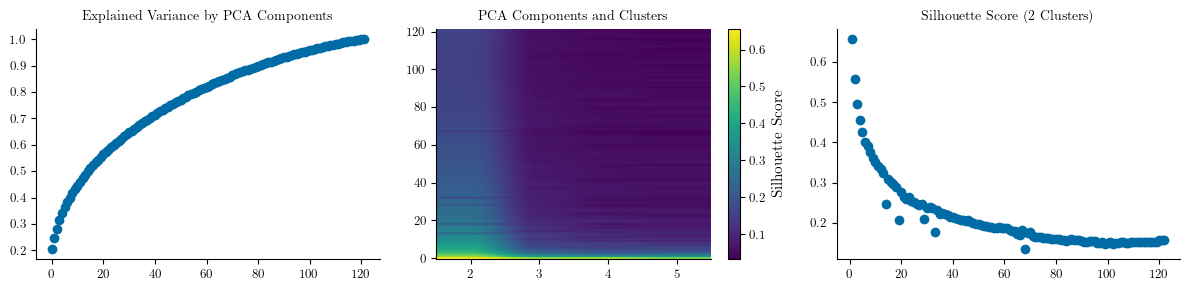

In [15]:
expl_var = pca.explained_variance_ratio_.cumsum()

# Evalueate silhouette score for different combianation of components and number of clusters
siluhette_all = []
for j in range(1, pca.n_components_ + 1):
    for i in range(2,6):
        clustering = AgglomerativeClustering(n_clusters=i, metric='euclidean')
        labels = clustering.fit_predict(fcs_ms_pca[:, :j])
        sil_score = silhouette_score(fcs_ms_pca[:, :j], labels)
        siluhette_all.append((j, i, sil_score))

silhouette_reshaped = np.array(siluhette_all)[:, 2].reshape(pca.n_components_, 4)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Explained Variance by PCA Components
axes[0].scatter(range(len(expl_var)), expl_var)
axes[0].set_title("Explained Variance by PCA Components")

# PCA Components and Clusters
im = axes[1].imshow(silhouette_reshaped, aspect='auto', origin='lower')
axes[1].set_xticks(ticks=range(4))
axes[1].set_xticklabels(['2','3','4','5'])
axes[1].set_title('PCA Components and Clusters')
fig.colorbar(im, ax=axes[1], label='Silhouette Score')

# Silhouette Score (2 Clusters)
axes[2].scatter(range(1,pca.n_components_ + 1), silhouette_reshaped[:, 0])
axes[2].set_title('Silhouette Score (2 Clusters)')

plt.tight_layout()
plt.show()

C:\Users\lucat\AppData\Local\Temp\ipykernel_28268\1489864651.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["EDSS", "BPF", "SDMT", "Lesion Load", "Disease Duration"])


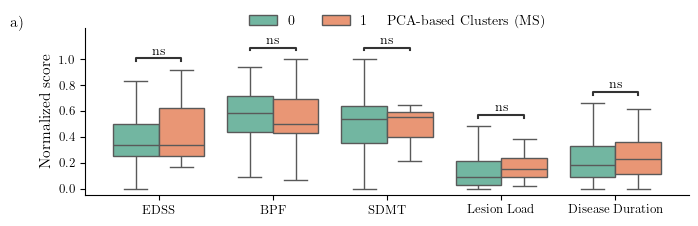

In [16]:
# Test clinical differences betweeen groups 
df_pca_ms = df_sel[ms_mask].copy()
clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean')
labels = clustering.fit_predict(fcs_ms_pca[:, :])
df_pca_ms['PCA_Cluster'] = labels

# Define columns
features_to_test = ["EDSS", "BPF", "SDMT", "lesion_load", "disease_duration"]
cluster_col = "PCA_Cluster"

# Normalize features using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = df_pca_ms[features_to_test].copy()
df_scaled[features_to_test] = scaler.fit_transform(df_scaled[features_to_test])
df_scaled[cluster_col] = df_pca_ms[cluster_col]  # Add cluster column back

# Reshape to long format for seaborn
df_plot = pd.melt(
    df_scaled.dropna(),
    id_vars=[cluster_col],
    value_vars=features_to_test,
    var_name="Feature",
    value_name="Score"
)

# Convert types
df_plot[cluster_col] = df_plot[cluster_col]
df_plot["Score"] = pd.to_numeric(df_plot["Score"], errors='coerce')

# Unique cluster and feature levels
cluster_levels = sorted(df_plot[cluster_col].unique())
feature_levels = features_to_test

# Define annotation pairs per feature
pairs = [
    ((feat, c1), (feat, c2))
    for feat in feature_levels
    for i, c1 in enumerate(cluster_levels)
    for c2 in cluster_levels[i+1:]
]

# Plot
plt.figure(figsize=(18/2.54, 6/2.54))
ax = sns.boxplot(
    x="Feature",
    y="Score",
    hue=cluster_col,
    data=df_plot,
    palette="Set2",
    showfliers=False
)

# Remove duplicate legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(cluster_levels)], labels[:len(cluster_levels)], title=cluster_col)

# Annotate statistical comparisons
annot = Annotator(
    ax,
    pairs=pairs,
    data=df_plot,
    x="Feature",
    y="Score",
    hue=cluster_col,
    order=feature_levels,
    hue_order=cluster_levels,
    text_format="star",
    loc="inside"
)
annot.configure(test="Mann-Whitney", comparisons_correction="fdr_bh",
                hide_non_significant=False, verbose=False)
annot.apply_and_annotate()
ax.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.37, 1.15),
           ncol=len(handles), frameon=False)
ax.text(2, 1.26, "PCA-based Clusters (MS)", fontweight='bold')
ax.set_xlabel("")  
ax.set_xticklabels(["EDSS", "BPF", "SDMT", "Lesion Load", "Disease Duration"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("Normalized score")

ax.text(-1.3, 1.25, "a)", fontsize=11, fontweight="bold")
plt.savefig(FIG_DIR / "PCA_Clusters.png", dpi=300)
plt.show()

## Umap Clustering (FC)

In [17]:
# select MS
group_col = "Group"
grp = df_sel[group_col].astype(str).str.upper().values
ms_mask = (grp == "MS")

# fc of MS
fcs_ms = fcs_all[ms_mask]

# Scaler
fcs_ms_vectorized = np.array([fc[np.triu_indices_from(fc, k=1)] for fc in fcs_ms])
scaler = StandardScaler()
fcs_ms_scaled = scaler.fit_transform(fcs_ms_vectorized)

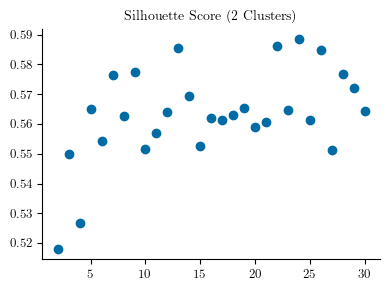

In [18]:
# Evalueate silhouette score for different MDS components and number of clusters
siluhette_all = []
max_comp = 30 
for i in range(2, max_comp + 1):
    umap_ms = umap.UMAP(n_components=i)
    embed_umap_ms = np.asarray(umap_ms.fit_transform(fcs_ms_scaled))
    clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean')
    labels = clustering.fit_predict(embed_umap_ms)
    sil_score = silhouette_score(embed_umap_ms, labels)
    siluhette_all.append(sil_score)

plt.figure(figsize=(4,3))
plt.scatter(range(2, max_comp + 1), np.array(siluhette_all))
plt.title('Silhouette Score (2 Clusters)')
plt.show()

C:\Users\lucat\AppData\Local\Temp\ipykernel_28268\4194640066.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["EDSS", "BPF", "SDMT", "Lesion Load", "Disease Duration"])


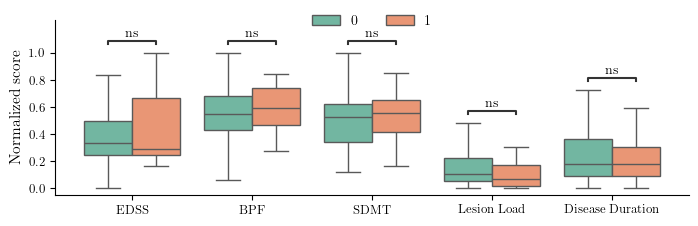

In [19]:
df_umap_ms = df_sel[ms_mask].copy()
umap_ms = umap.UMAP(n_components=2, metric='correlation')
embed_umap_ms = np.asarray(umap_ms.fit_transform(fcs_ms_scaled))
clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean')
labels = clustering.fit_predict(embed_umap_ms[:, :])
df_umap_ms['UMAP_Cluster'] = labels

# Define columns
features_to_test = ["EDSS", "BPF", "SDMT", "lesion_load", "disease_duration"]
cluster_col = "UMAP_Cluster"

# Normalize features using Min-Max scaling
df_scaled = df_umap_ms[features_to_test].copy()
scaler = MinMaxScaler()
df_scaled[features_to_test] = scaler.fit_transform(df_scaled[features_to_test])
df_scaled[cluster_col] = df_umap_ms[cluster_col]  # Add cluster column back

# Reshape to long format for seaborn
df_plot = pd.melt(
    df_scaled.dropna(),
    id_vars=[cluster_col],
    value_vars=features_to_test,
    var_name="Feature",
    value_name="Score"
)

# Convert types
df_plot[cluster_col] = df_plot[cluster_col]
df_plot["Score"] = pd.to_numeric(df_plot["Score"], errors='coerce')

# Unique cluster and feature levels
cluster_levels = sorted(df_plot[cluster_col].unique())
feature_levels = features_to_test

# Define annotation pairs per feature
pairs = [
    ((feat, c1), (feat, c2))
    for feat in feature_levels
    for i, c1 in enumerate(cluster_levels)
    for c2 in cluster_levels[i+1:]
]

# Plot
plt.figure(figsize=(18/2.54, 6/2.54))
ax = sns.boxplot(
    x="Feature",
    y="Score",
    hue=cluster_col,
    data=df_plot,
    palette="Set2",
    showfliers=False
)

# Remove duplicate legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(cluster_levels)], labels[:len(cluster_levels)], title=cluster_col)

# Annotate statistical comparisons
annot = Annotator(
    ax,
    pairs=pairs,
    data=df_plot,
    x="Feature",
    y="Score",
    hue=cluster_col,
    order=feature_levels,
    hue_order=cluster_levels,
    text_format="star",
    loc="inside"
)
annot.configure(test="Mann-Whitney", comparisons_correction="fdr_bh",
                hide_non_significant=False, verbose=False)
annot.apply_and_annotate()
ax.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.50, 1.1),
           ncol=len(handles), frameon=False)
ax.set_xlabel("")  # rimuove "Feature"
ax.set_xticklabels(["EDSS", "BPF", "SDMT", "Lesion Load", "Disease Duration"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("Normalized score")

plt.savefig(FIG_DIR / "UMAP_clusters.png", dpi=300)
plt.show()

## Consensus clustering Umap (FC)

In [ ]:
# Organize data
df_umap_ms = df_sel[ms_mask].copy()
X = fcs_ms_scaled.copy()
k = 2

# Umap
n_components = 10
umap_metric = "correlation"  # tried also euclidean, cosine

# Runs umap + clustering with PAC monitoring
max_runs = 200          
min_runs = 80           
window = 10           
tol = 0.01         

n = X.shape[0]
coassoc = np.zeros((n, n), dtype=float)
pac_hist = []

# Loop
runs_done = 0
for s in range(max_runs):
    Z = np.asarray(
        umap.UMAP(
            n_components=n_components,
            metric=umap_metric,
            random_state=s
        ).fit_transform(X)
    )
    labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(Z)

    for c in range(k):
        idx = np.where(labels == c)[0]
        coassoc[np.ix_(idx, idx)] += 1.0

    runs_done += 1

    # Estimate C and PAC
    C = coassoc / runs_done
    np.fill_diagonal(C, 1.0)
    pac = compute_pac(C)
    pac_hist.append(pac)

    print(f"Run {runs_done:3d}/{max_runs} | PAC={pac:.4f}")

    # Early stopping check
    if runs_done >= min_runs and len(pac_hist) >= window + 1:
        recent = np.array(pac_hist[-window:])
        diffs = np.abs(np.diff(recent))
        if diffs.mean() < tol:
            print(f"Early stopping a {runs_done} run: ΔPAC medio({window})={diffs.mean():.4f} < {tol}")
            break

# Final consensus clustering
C_final = coassoc / runs_done
np.fill_diagonal(C_final, 1.0)
D = 1.0 - C_final

consensus_labels = AgglomerativeClustering(n_clusters=k, linkage='average', metric='precomputed').fit_predict(D)
df_umap_ms['UMAP_Consensus'] = consensus_labels

df_umap_ms.attrs['pac_hist'] = pac_hist
df_umap_ms.attrs['runs_done'] = runs_done

C:\Users\lucat\AppData\Local\Temp\ipykernel_28268\3006024222.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["EDSS", "BPF", "SDMT", "Lesion Load", "Disease Duration"])


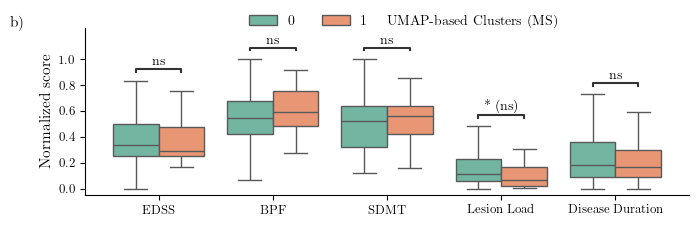

In [22]:
# Define columns
features_to_test = ["EDSS", "BPF", "SDMT", "lesion_load", "disease_duration"]
cluster_col = "UMAP_Consensus"

# Normalize features using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = df_umap_ms[features_to_test].copy()
df_scaled[features_to_test] = scaler.fit_transform(df_scaled[features_to_test])
df_scaled[cluster_col] = df_umap_ms[cluster_col]  # Add cluster column back

# Reshape to long format for seaborn
df_plot = pd.melt(
    df_scaled.dropna(),
    id_vars=[cluster_col],
    value_vars=features_to_test,
    var_name="Feature",
    value_name="Score"
)

# Convert types
df_plot[cluster_col] = df_plot[cluster_col].astype(int)
df_plot["Score"] = pd.to_numeric(df_plot["Score"], errors='coerce')

# Unique cluster and feature levels
cluster_levels = sorted(df_plot[cluster_col].unique())
feature_levels = features_to_test

# Define annotation pairs per feature
pairs = [
    ((feat, c1), (feat, c2))
    for feat in feature_levels
    for i, c1 in enumerate(cluster_levels)
    for c2 in cluster_levels[i+1:]
]

# Plot
plt.figure(figsize=(18/2.54, 6/2.54))
ax = sns.boxplot(
    x="Feature",
    y="Score",
    hue=cluster_col,
    data=df_plot,
    palette="Set2",
    showfliers=False
)

# Remove duplicate legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(cluster_levels)], labels[:len(cluster_levels)], title=cluster_col)

# Annotate statistical comparisons
annot = Annotator(
    ax,
    pairs=pairs,
    data=df_plot,
    x="Feature",
    y="Score",
    hue=cluster_col,
    order=feature_levels,
    hue_order=cluster_levels,
    text_format="star",
    loc="inside"
)
annot.configure(test="Mann-Whitney", comparisons_correction="fdr_bh",
                hide_non_significant=False, verbose=False)
annot.apply_and_annotate()
ax.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.37, 1.15),
           ncol=len(handles), frameon=False)
ax.text(2, 1.26, "UMAP-based Clusters (MS)", fontweight='bold')
ax.set_xlabel("")  
ax.set_xticklabels(["EDSS", "BPF", "SDMT", "Lesion Load", "Disease Duration"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("Normalized score")
ax.text(-1.3, 1.25, "b)", fontsize=11, fontweight="bold")
plt.savefig(FIG_DIR / "UMAP_Clusters_consensus.png", dpi=300)
plt.show()

## HMM States

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


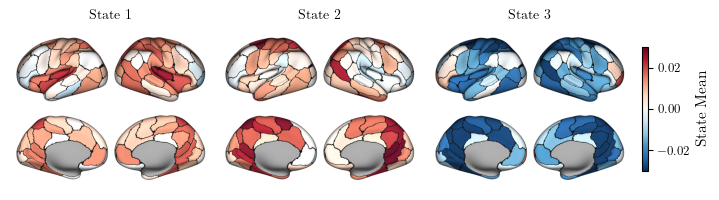

In [20]:
# Fix for numpy deprecation of np.bool
np_bool = np.bool_

# Surface visualization of HMM state means
# Parameters
n_parc = 100
n_states = means_orig.shape[0]
surface_space = "conte69"

color_range = (-0.03, 0.03)
titles = [f"State {i+1}" for i in range(n_states)]

output_dir = FIG_DIR / "temp_state_images"
output_dir.mkdir(parents=True, exist_ok=True)

# Surfaces
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]

# Parcellation
schaefer = nntdata.fetch_schaefer2018("fslr32k")[f"{n_parc}Parcels7Networks"]
parcellator = Parcellater(dlabel_to_gifti(schaefer), "fsLR")
lh_parc, rh_parc = load_parcellation("schaefer", scale=n_parc)

# Plot and save single state images
for i in range(n_states):

    means_state = means_orig[i, :]

    surf_data = parcel_to_surface(means_state, f"schaefer_{n_parc}_{surface_space}")
    half = len(surf_data) // 2
    data_lh, data_rh = surf_data[:half], surf_data[half:]

    p = Plot(lh, rh)
    p.add_layer({"left": data_lh, "right": data_rh},
                cmap="RdBu_r", cbar=False, color_range=color_range)
    p.add_layer({"left": lh_parc, "right": rh_parc},
                cmap="gray", as_outline=True, cbar=False)

    fig = p.build(scale=(10, 10), colorbar=False)
    fig.savefig(output_dir / f"means_state{i+1}.png", dpi=500, bbox_inches="tight")
    plt.close(fig)

# Panel figure
fig, axes = plt.subplots(1, n_states, figsize=(18/2.54, 5/2.54), constrained_layout=True)
axes = np.array(axes if isinstance(axes, np.ndarray) else [axes], dtype=object)

for i in range(n_states):
    img = mpimg.imread(output_dir / f"means_state{i+1}.png")
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(titles[i])

sm = cm.ScalarMappable(cmap="RdBu_r")
sm.set_clim(*color_range)
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.01, pad=0.02)
cbar.set_label("State Mean")

plt.show()


In [ ]:
# Statistical comparison of correlation matrices
n_states = fcs_orig.shape[0]
n_rois = fcs_orig.shape[1]
sorted_indices = np.argsort(network_labels)
sorted_labels = network_labels[sorted_indices]
unique_networks = np.unique(sorted_labels)

# compute mean FC across all subjects
fc_mean = np.mean(fcs_all, axis=0)

# Pre-sort all FC matrices
sorted_covs = fcs_orig[:, sorted_indices, :][:, :, sorted_indices]
sorted_avg_fc = fc_mean[sorted_indices, :][:, sorted_indices]

# Index ranges for each RSN
rsn_indices = []
for net in unique_networks:
    idx = np.where(sorted_labels == net)[0]
    rsn_indices.append(idx)

# Compute stats and p-values
all_stats = []  # Effect size (mean diff)
all_pvals = []  # Raw p-values
all_pvals_corrected = []  # FDR- or Bonferroni-corrected

for k in range(n_states):
    stats_matrix = np.zeros((len(unique_networks), len(unique_networks)))
    pval_matrix = np.ones((len(unique_networks), len(unique_networks)))
    
    for i, idx_i in enumerate(rsn_indices):
        for j, idx_j in enumerate(rsn_indices):
            block_state = sorted_covs[k][np.ix_(idx_i, idx_j)].flatten()
            block_avg = sorted_avg_fc[np.ix_(idx_i, idx_j)].flatten()

            # Permutation test
            result = permutation_test(
                (block_state, block_avg),
                #statistic=cliff_delta,
                statistic=lambda a, b: np.mean(a) - np.mean(b),
                n_resamples=10000,
                alternative='two-sided',
                random_state=23
                )
            stats_matrix[i, j] = result.statistic
            pval_matrix[i, j] = result.pvalue

    all_stats.append(stats_matrix)
    all_pvals.append(pval_matrix)

    # Multiple comparison correction
    pvals_flat = pval_matrix.flatten()
    _, pvals_corr, _, _ = multipletests(pvals_flat, method='bonferroni')
    pval_corr_matrix = pvals_corr.reshape(pval_matrix.shape)
    all_pvals_corrected.append(pval_corr_matrix)

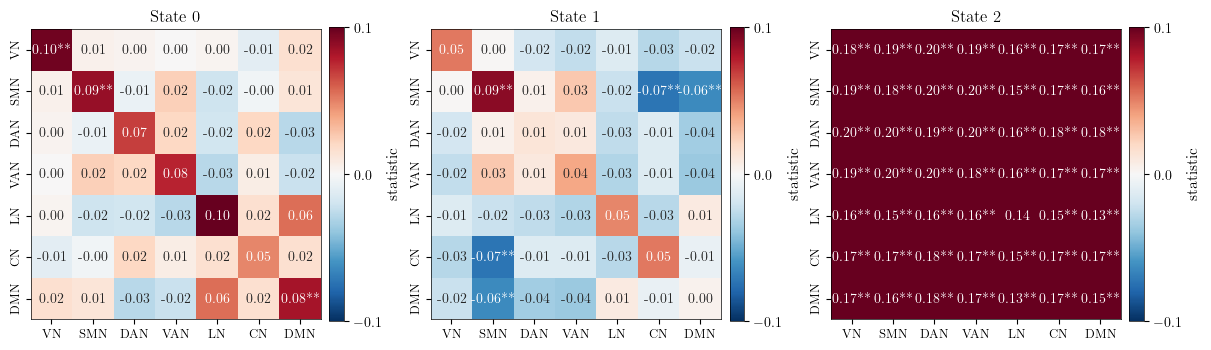

In [30]:
vminvmax = [-0.1, 0.1]

# Create horizontal subplots
fig, axes = plt.subplots(nrows=1, ncols=len(all_stats), figsize=(4 * len(all_stats), 4), constrained_layout=True)

if len(all_stats) == 1:
    axes = [axes]

for k, (stat_matrix, pval_matrix) in enumerate(zip(all_stats, all_pvals_corrected)):
    annotations = np.empty(stat_matrix.shape, dtype=object)
    for i in range(stat_matrix.shape[0]):
        for j in range(stat_matrix.shape[1]):
            val = stat_matrix[i, j]
            star = significance_stars(pval_matrix[i, j])
            annotations[i, j] = f"{val:.2f}{star}"

    ax = sns.heatmap(stat_matrix, xticklabels=network_names[:7], yticklabels=network_names[:7], annot=annotations,
                     fmt="", cmap="RdBu_r", center=0, vmin=vminvmax[0], vmax=vminvmax[1], square=True,
                     cbar_kws={'label': 'statistic', 'shrink': 0.75, 'pad': 0.03},
                     ax=axes[k])

    # Style plot borders
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)

    # Style colorbar
    cbar = ax.collections[0].colorbar
    if cbar:
        cbar.outline.set_edgecolor('black') #type: ignore
        cbar.set_ticks([vminvmax[0], 0, vminvmax[1]])
        cbar.outline.set_linewidth(0.5) # type: ignore
        cbar.ax.tick_params(labelsize=10)

    ax.set_title(f'State {k}', fontsize=12)

plt.show()

## Panel 2

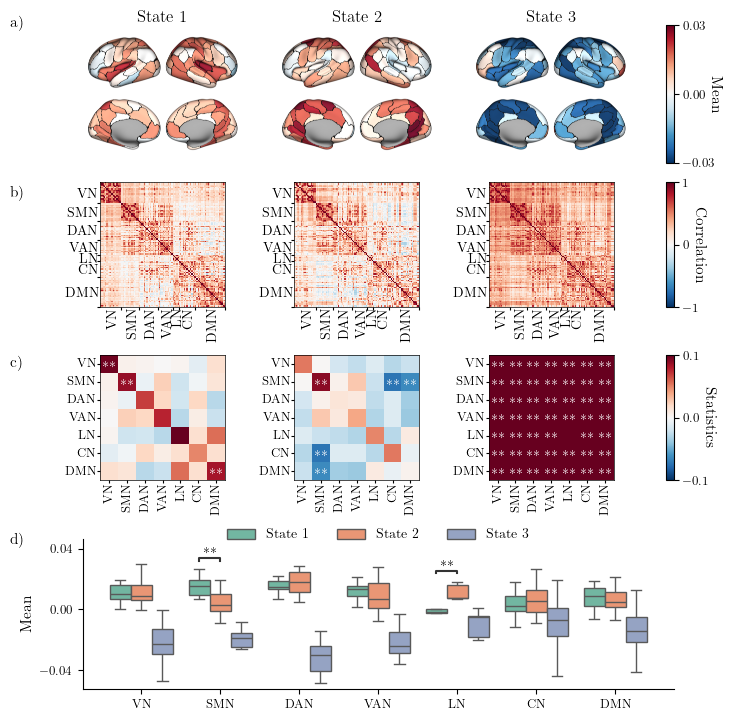

In [ ]:
# Setting variables for panel 2
corr_range = (-1, 1)
selected_states = [0, 1, 2]
selected_state_labels = [f"State {s+1}" for s in selected_states]

# Mean of states averaged within each RSN
rows = []
for s in selected_states:
    for roi in range(means_orig.shape[1]):
        rsn_label = int(network_labels[roi])
        rsn_name = network_names[rsn_label]
        rows.append({"State": f"State {s+1}", "RSN": rsn_name, "Activation": float(means_orig[s, roi])})

df_means_selected = pd.DataFrame(rows)

# Order the rois
sorted_indices = np.argsort(network_labels)
sorted_labels = network_labels[sorted_indices]
unique_networks = np.unique(sorted_labels)
rsn_labels = [network_names[int(i)] for i in unique_networks]

state_labels = sorted(df_means_selected["State"].unique())
pairs_meanbox = [((rsn, s1), (rsn, s2))
                 for rsn in rsn_labels
                 for i, s1 in enumerate(state_labels)
                 for s2 in state_labels[i+1:]]

# ============
# Panel Figure
# ============
fig = plt.figure(figsize=(18/2.54, 18/2.54), constrained_layout=True)
gs = gridspec.GridSpec(
    4, 4, figure=fig,
    width_ratios=[1, 1, 1, 0.05],
    height_ratios=[1.1, 1, 1, 1.2]
)

# Row 1: Surface plots
for i in range(n_states):
    ax = fig.add_subplot(gs[0, i])
    img = mpimg.imread(FIG_DIR / "temp_state_images" / f"means_state{i+1}.png")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"State {i+1}", fontsize=12)

sm = cm.ScalarMappable(cmap="RdBu_r")
sm.set_clim(*color_range)
cax_surface = fig.add_subplot(gs[0, 3])
cbar = fig.colorbar(sm, cax=cax_surface)
cbar.set_label("Mean", rotation=270)
cbar.set_ticks([color_range[0], 0, color_range[1]])

# Row 2: FC matrices
matrix_axes = [fig.add_subplot(gs[1, i]) for i in range(n_states)]
plot_matrices_to_axes_no_cbar(
    fcs_orig,
    matrix_axes,
    network_labels,
    network_names,
    titles=None,
    vminvmax=corr_range,
    cmap="RdBu_r",
    sort=True
)

sm_corr = cm.ScalarMappable(cmap="RdBu_r")
sm_corr.set_clim(*corr_range)
cax_matrix = fig.add_subplot(gs[1, 3])
cbar2 = fig.colorbar(sm_corr, cax=cax_matrix)
cbar2.set_label("Correlation", rotation=270)
cbar2.set_ticks([-1, 0, 1])

# Row 3: Statistical comparison of FC states vs average FC
for k in range(n_states):
    ax = fig.add_subplot(gs[2, k])
    stat_matrix = all_stats[k]
    pval_matrix = all_pvals_corrected[k]

    annotations = np.array([[significance_stars(pval_matrix[i, j])
                             for j in range(stat_matrix.shape[1])]
                            for i in range(stat_matrix.shape[0])])

    sns.heatmap(
        stat_matrix,
        annot=annotations,
        fmt="",
        xticklabels=network_names[:7],
        yticklabels=network_names[:7],
        cmap="RdBu_r",
        center=0,
        vmin=-0.1,
        vmax=0.1,
        square=True,
        ax=ax,
        cbar=False
    )

    ax.tick_params(axis="both", length=2, pad=1)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(0.5)

sm_stats = cm.ScalarMappable(cmap="RdBu_r")
sm_stats.set_clim(-0.1, 0.1)
cax_stats = fig.add_subplot(gs[2, 3])
cbar_stats = fig.colorbar(sm_stats, cax=cax_stats)
cbar_stats.set_label("Statistics", rotation=270)
cbar_stats.set_ticks([-0.1, 0, 0.1])

# Row 4: Boxplot means of states averaged within each RSN
ax_box = fig.add_subplot(gs[3, :])
sns.boxplot(
    data=df_means_selected,
    x="RSN",
    y="Activation",
    hue="State",
    showfliers=False,
    palette="Set2",
    order=rsn_labels,
    ax=ax_box
)

handles, labels = ax_box.get_legend_handles_labels()
ax_box.legend(handles[:len(state_labels)], labels[:len(state_labels)],
              loc="upper center", bbox_to_anchor=(0.5, 1.15),
              ncol=len(state_labels), frameon=False)

ax_box.spines["top"].set_visible(False)
ax_box.spines["right"].set_visible(False)
ax_box.set_title("")
ax_box.set_xlabel("")
ax_box.set_ylabel("Mean")
ax_box.set_yticks([-0.04, 0.00, 0.04])

# Annotate pairwise comparisons between states 1 and 2 (the most interesting in this analyses)
pairs_meanbox = [
    ((rsn, "State 1"), (rsn, "State 2"))
    for rsn in rsn_labels
]

annot = Annotator(
    ax_box,
    pairs=pairs_meanbox,
    data=df_means_selected,
    x="RSN",
    y="Activation",
    hue="State",
    order=rsn_labels,
    hue_order=state_labels,
    text_format="star",
    loc="inside"
)
annot.configure(test="Mann-Whitney", comparisons_correction="fdr_bh",
                hide_non_significant=True, verbose=False)
annot.apply_and_annotate()

# Labels
fig.text(-0.01, 0.97, "a)", fontsize=11, fontweight="bold")
fig.text(-0.01, 0.73, "b)", fontsize=11, fontweight="bold")
fig.text(-0.01, 0.49, "c)", fontsize=11, fontweight="bold")
fig.text(-0.01, 0.24, "d)", fontsize=11, fontweight="bold")

fig.savefig( FIG_DIR / "Panel_2_HMM.png", dpi=400, bbox_inches="tight")
plt.show()


## Panel 3 

In [26]:
# Group comparison 
metrics_state = ["FO_soft", "Dwell"]  # per-state metrics to be compared
states = sorted(df_hmm["State"].unique())

tests, pvals = [], []

# MS vs HC within each state
for metric in metrics_state:
    for st in states:
        grp_ms = df_hmm.query("Group=='MS' and State==@st")[metric].dropna()
        grp_hc = df_hmm.query("Group=='HC' and State==@st")[metric].dropna()
        p = mannwhitneyu(grp_ms, grp_hc, alternative="two-sided").pvalue
        tests.append((metric, st))
        pvals.append(p)

# MS vs HC for switching rate
cols_sr = ["participant_id", "Group", "SwitchRate"]

# Take the first (and only) row per participant, since SwitchRate is the same across states
df_sr = (df_hmm.groupby("participant_id", as_index=False).agg(Group=("Group", "first"),SwitchRate=("SwitchRate", "first")))
sr_ms = df_sr.query("Group=='MS'")["SwitchRate"].dropna()
sr_hc = df_sr.query("Group=='HC'")["SwitchRate"].dropna()
p_sr = mannwhitneyu(sr_ms, sr_hc, alternative="two-sided").pvalue
tests.append(("SwitchRate", None))
pvals.append(p_sr)

# FDR (global over all tests above)
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
results_panel3 = {
    test: {"p_unc": p_u, "p_fdr": p_f, "significant": sig}
    for test, p_u, p_f, sig in zip(tests, pvals, pvals_fdr, reject)
}

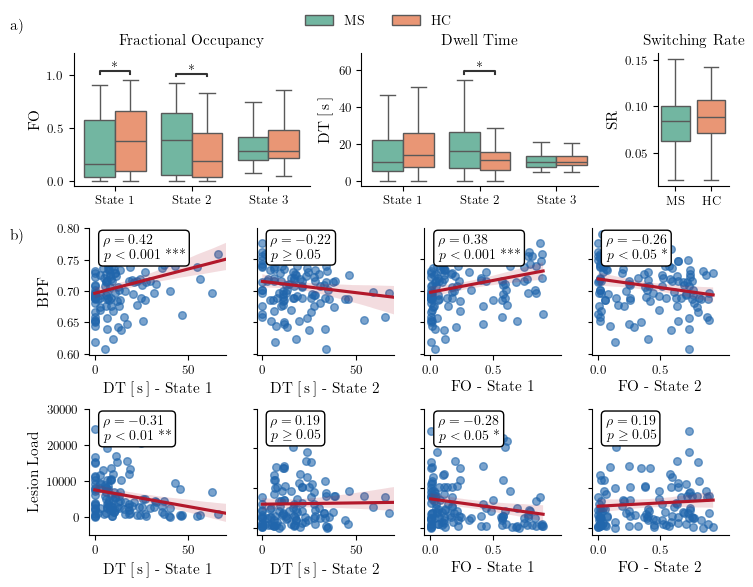

In [63]:
label_map_metrics = {"FO_soft": r"FO", "Dwell": r"DT [\,s\,]", "SwitchRate": r"SR"}

# ============
# Panel Figure
# ============
metrics_a = ["FO_soft", "Dwell", "SwitchRate"]
titles_a  = ["Fractional Occupancy", "Dwell Time", "Switching Rate"]

fig = plt.figure(figsize=(18/2.54, 14/2.54), constrained_layout=True)
outer_gs = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[1, 0.05, 2])
gs_a = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[0], width_ratios=[1, 1, 0.3])

states = sorted(df_hmm["State"].dropna().unique())


for i, (metric, title) in enumerate(zip(metrics_a, titles_a)):
    ax = fig.add_subplot(gs_a[0, i])

    if metric != "SwitchRate":
        sns.boxplot(
            data=df_hmm,
            x="State", y=metric, hue="Group",
            showfliers=False, palette="Set2", ax=ax
        )

        pairs = [((st, "MS"), (st, "HC")) for st in states]
        pvals = [results_panel3[(metric, st)]["p_fdr"] for st in states]
        sigs  = [results_panel3[(metric, st)]["significant"] for st in states]

        pairs = [p for p, s in zip(pairs, sigs) if s]
        pvals = [p for p, s in zip(pvals, sigs) if s]

        if pairs:
            annot = Annotator(
                ax, pairs=pairs, data=df_hmm,
                x="State", y=metric, hue="Group",
                order=states, hue_order=["MS", "HC"]
            )
            annot.configure(test=None, text_format="star", loc="inside", verbose=False)
            annot.set_pvalues(pvals)
            annot.annotate()

        ax.get_legend().remove()

    else:
        sns.boxplot(
            data=df_sr,
            x="Group", y="SwitchRate", hue="Group",
            palette="Set2", legend=False, showfliers=False, ax=ax
        )

        if results_panel3[(metric, None)]["significant"]:
            pval_sr = results_panel3[(metric, None)]["p_fdr"]
            annot = Annotator(
                ax, pairs=[("MS", "HC")], data=df_sr,
                x="Group", y="SwitchRate", order=["MS", "HC"]
            )
            annot.configure(test=None, text_format="star", loc="inside", verbose=False)
            annot.set_pvalues([pval_sr])
            annot.annotate()

    ax.set_title(title, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel(label_map_metrics.get(metric, metric))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Global legend (from first subplot)
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.50, 1.05), ncol=2, frameon=False)

# Correlations metrics and clinical variables (MS)
df_corr = df_hmm_corr

id_col = "participant_id"
group_col = "Group" if "Group" in df_hmm.columns else "group"

df_ms_hmm  = df_hmm[df_hmm[group_col].astype(str).eq("MS")].copy()
df_ms_clin = df_sel[df_sel[group_col].astype(str).eq("MS")].copy()
df_merged = df_ms_hmm.merge(df_ms_clin, on=id_col, suffixes=("", "_clin"))

metrics_to_plot       = ["Dwell", "FO_soft"]
clinical_vars_to_plot = ["BPF", "lesion_load"]
states_to_plot        = ["State 1", "State 2"]

scatter_color = "#2166ac"
line_color    = "#b2182b"
label_map     = {"BPF": "BPF", "lesion_load": "Lesion Load"}

nrows = len(clinical_vars_to_plot)
ncols = len(metrics_to_plot) * len(states_to_plot)
gs_b = gridspec.GridSpecFromSubplotSpec(nrows, ncols, subplot_spec=outer_gs[2], wspace=0.15)

for r, clin_var in enumerate(clinical_vars_to_plot):
    for m, metric in enumerate(metrics_to_plot):
        for s, st in enumerate(states_to_plot):
            c = m * len(states_to_plot) + s
            ax = fig.add_subplot(gs_b[r, c])

            df_state = df_merged[df_merged["State"] == st].copy()

            x = df_state[metric]
            y = df_state[clin_var]

            info = df_corr.query(
                "State == @st and HMM_metric == @metric and Clinical_var == @clin_var"
            )
            if info.empty:
                ax.axis("off")
                continue

            rho   = float(info["Spearman_rho"].iloc[0])
            p_fdr = float(info["p_fdr"].iloc[0])

            sns.regplot(
                x=x, y=y, ax=ax,
                scatter_kws={"s": 30, "alpha": 0.6, "color": scatter_color},
                line_kws={"color": line_color}, 
            )

            metric_label = label_map_metrics.get(metric, metric)
            ax.set_xlabel(f"{metric_label} - {st}")

            if metric == "Dwell":
                ax.set_xticks([0, 50])
                ax.set_xlim(-3, 70)
            elif metric == "FO_soft":
                ax.set_xticks([0, 0.5])
                ax.set_xlim(-0.05, 1.05)
            
            if clin_var == "lesion_load":
                ax.set_ylim(top=30000)
                
            if c == 0:
                ax.set_ylabel(label_map.get(clin_var, clin_var))
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])
                ax.tick_params(axis="y", length=3)

            if clin_var == "lesion_load":
                ax.set_ylim(top=30000)

            textstr = r"$\rho = %.2f$" % rho + "\n" + p_text(p_fdr)
            ax.text(
                0.1, 0.95, textstr,
                transform=ax.transAxes, fontsize=10, va="top",
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
            )

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

# Panel labels
fig.text(-0.02, 1.0, "a)", fontsize=11, fontweight="bold")
fig.text(-0.02, 0.62, "b)", fontsize=11, fontweight="bold")

fig.savefig(FIG_DIR / "Panel_3_HMM.png", dpi=400, bbox_inches="tight")
plt.show()

## Panel 4 

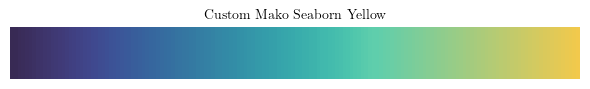

In [15]:
# Custom map
yellow = np.array([242/255, 201/255, 76/255])

base_cmap = sns.color_palette("mako", as_cmap=True)
mako_trim = base_cmap(np.linspace(0.2, 0.8, 100))[:, :3]

transition = (np.linspace(0, 1, 56)[:, None] * yellow +
              (1 - np.linspace(0, 1, 56)[:, None]) * mako_trim[-1])

new_colors = np.vstack([mako_trim, transition])
custom_cmap = ListedColormap(new_colors)
gradient = np.linspace(0, 1, 560).reshape(1, -1)
plt.figure(figsize=(6, 1))
plt.imshow(gradient, aspect='auto', cmap=custom_cmap)
plt.axis('off')
plt.title("Custom Mako Seaborn Yellow", fontsize=10)
plt.show()

In [16]:
# Prepare data
id_col = "participant_id"
group_col = "Group" if "Group" in df_sel.columns else "group"

cluster_map = {0: "Severe", 1: "Mild"}
cluster_order = ["Severe", "Mild"]

x_mds = "OT_dim1"
y_mds = "OT_dim2"

features_to_plot = ["EDSS", "SDMT", "BPF", "lesion_load"]

# Palette
base_pal = sns.color_palette("Set2", 2)
palette_SM = {"Severe": base_pal[0], "Mild": base_pal[1]}

# Heatmap data: MS x MS
C_full = np.asarray(cost_dir, float)
is_ms = df_sel[group_col].astype(str).eq("MS").to_numpy()
ms_idx = np.flatnonzero(is_ms)

C_ms = C_full[np.ix_(ms_idx, ms_idx)]
np.fill_diagonal(C_ms, 0.0)

df_ms = df_sel.loc[is_ms].copy()
if "OT_Cluster" not in df_ms.columns:
    df_ms = df_ms.merge(df_ms_ot_clusters[[id_col, "OT_cluster"]], on=id_col, how="left")
    df_ms["OT_Cluster"] = df_ms["OT_cluster"]

df_ms["ClusterName"] = df_ms["OT_Cluster"].map(cluster_map)

cat = pd.Categorical(df_ms["ClusterName"], categories=cluster_order, ordered=True)
sort_idx = np.argsort(cat.codes)

C_plot = C_ms[np.ix_(sort_idx, sort_idx)]
clusters_plot = df_ms["ClusterName"].to_numpy()[sort_idx]

vmin, vmax = 0, np.percentile(C_plot, 99)

# MDS data
ms_scatter = df_ms_ot_clusters.copy()
ms_scatter["ClusterName"] = ms_scatter["OT_cluster"].map(cluster_map)
cols_to_check: list[str] = [x_mds, y_mds, "ClusterName"]

ms_scatter = (
    ms_scatter.loc[ms_scatter[group_col].astype(str).eq("MS")]
    .copy()
)

# Boxplot data
ms_box = df_ms_ot_clusters.copy()
ms_box["ClusterName"] = ms_box["OT_cluster"].map(cluster_map)
ms_box = ms_box.loc[ms_box[group_col].astype(str).eq("MS")].copy()

scaler = MinMaxScaler()
df_scaled = ms_box[["ClusterName"] + features_to_plot].copy()
df_scaled[features_to_plot] = scaler.fit_transform(df_scaled[features_to_plot])

df_plot = pd.melt(
    df_scaled,
    id_vars=["ClusterName"],
    value_vars=features_to_plot,
    var_name="Feature",
    value_name="Score"
)

p_lookup = df_clust_diff.set_index("Variable")["p_fdr_main"].to_dict()
feat_levels = [f for f in features_to_plot if f in p_lookup]

alpha = 0.05
pairs_sig = [((feat, "Severe"), (feat, "Mild")) for feat in feat_levels if p_lookup[feat] < alpha]
pvals_sig = [p_lookup[feat] for feat in feat_levels if p_lookup[feat] < alpha]

C:\Users\lucat\AppData\Local\Temp\ipykernel_20156\1766491306.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_c.set_xticklabels(["EDSS", "SDMT", "BPF", "Lesion Load"][:len(feat_levels)])


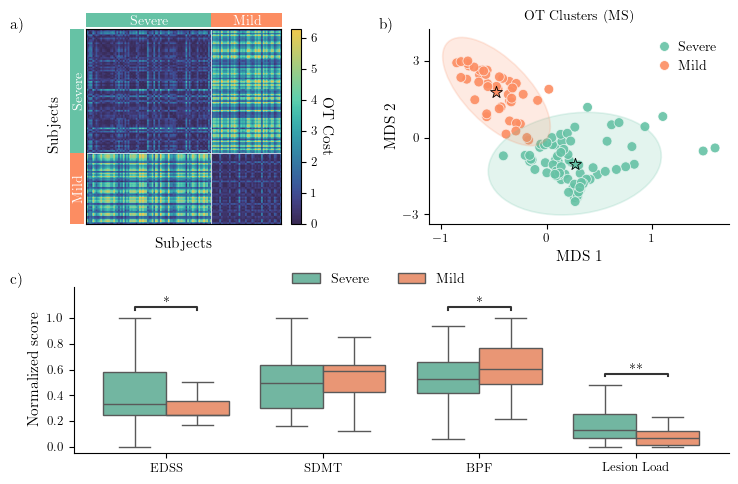

In [19]:
# ============
# Panel Figure
# ============
fig = plt.figure(figsize=(18/2.54, 12/2.54), constrained_layout=True)
outer = fig.add_gridspec(2, 2, height_ratios=[1, 0.85], width_ratios=[0.8, 1.0], hspace=0.1, wspace=0.1)

# Panel a: heatmap
ax_a = fig.add_subplot(outer[0, 0])
im = ax_a.imshow(C_plot, cmap=custom_cmap, vmin=vmin, vmax=vmax)

divider = make_axes_locatable(ax_a)
cax = divider.append_axes("right", size="5%", pad=0.10)
cax.set_in_layout(False)
cb = fig.colorbar(im, cax=cax)
cb.set_label("OT Cost", rotation=270, labelpad=12)

change = np.flatnonzero(clusters_plot[:-1] != clusters_plot[1:]) + 1
for b in change:
    ax_a.axhline(b - 0.5, color="white", lw=0.5)
    ax_a.axvline(b - 0.5, color="white", lw=0.5)

ax_a.set_xlabel("Subjects", labelpad=10)
ax_a.set_ylabel("Subjects", labelpad=18)
ax_a.spines["top"].set_visible(True)
ax_a.spines["right"].set_visible(True)
ax_a.set_xticks([])
ax_a.set_yticks([])

# Strip top and left
cmap_clusters = ListedColormap([palette_SM[k] for k in cluster_order])
codes = pd.Categorical(clusters_plot, categories=cluster_order, ordered=True).codes

ax_top = ax_a.inset_axes([0, 1.008, 1, 0.07])
ax_top.set_in_layout(False)
ax_top.imshow(codes[np.newaxis, :], aspect="auto", cmap=cmap_clusters, vmin=0, vmax=1)
ax_top.axis("off")

ax_left = ax_a.inset_axes([-0.08, 0, 0.07, 1])
ax_left.set_in_layout(False)
ax_left.imshow(codes[:, np.newaxis], aspect="auto", cmap=cmap_clusters, vmin=0, vmax=1)
ax_left.axis("off")

for g in cluster_order:
    idx = np.where(clusters_plot == g)[0]
    if idx.size:
        mid = (idx[0] + idx[-1] + 1) / 2.0
        ax_top.text(mid, 0.1, g, ha="center", va="center",
                    color="white", fontsize=10, fontweight="bold")
        ax_left.text(0.1, mid, g, ha="center", va="center",
                     color="white", fontsize=10, fontweight="bold", rotation=90)

# Panel b: scatter
ax_b = fig.add_subplot(outer[0, 1])
sns.scatterplot(
    data=ms_scatter, x=x_mds, y=y_mds,
    hue="ClusterName", hue_order=cluster_order,
    palette=palette_SM,
    edgecolor="white", linewidth=0.6, s=50, alpha=0.9, ax=ax_b
)
for lab in cluster_order:
    d = ms_scatter.loc[ms_scatter["ClusterName"] == lab]
    if len(d) >= 3:
        add_cov_ellipse(ax_b, d[x_mds].to_numpy(), d[y_mds].to_numpy(), palette_SM[lab])

ax_b.set_xlabel("MDS 1")
ax_b.set_ylabel("MDS 2")
ax_b.set_title("OT Clusters (MS)")
ax_b.legend(frameon=False, loc="best", handletextpad=0)
ax_b.set_yticks([-3, 0, 3])
ax_b.set_xticks([-1, 0, 1])

# Panel c: boxplot
ax_c = fig.add_subplot(outer[1, :])
sns.boxplot(
    data=df_plot, x="Feature", y="Score",
    hue="ClusterName", hue_order=cluster_order,
    order=feat_levels,
    palette=palette_SM, showfliers=False, ax=ax_c
)

handles, labels = ax_c.get_legend_handles_labels()
if ax_c.get_legend() is not None:
    ax_c.get_legend().remove()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.50, 0.46),
           ncol=len(handles), frameon=False)

if pairs_sig:
    annot = Annotator(
        ax_c, pairs=pairs_sig, data=df_plot,
        x="Feature", y="Score", hue="ClusterName",
        order=feat_levels, hue_order=cluster_order
    )
    annot.configure(test=None, text_format="star", loc="inside", verbose=False)
    annot.set_pvalues(pvals_sig)
    annot.annotate()

ax_c.set_xlabel("")
ax_c.set_xticklabels(["EDSS", "SDMT", "BPF", "Lesion Load"][:len(feat_levels)])
ax_c.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax_c.set_ylabel("Normalized score")

# Panel labels
fig.text(-0.02, 0.95, "a)", fontsize=11, fontweight="bold")
fig.text(0.50, 0.95, "b)", fontsize=11, fontweight="bold")
fig.text(-0.02, 0.41, "c)", fontsize=11, fontweight="bold")
fig.savefig(FIG_DIR / "panel_4_HMM.png", dpi=400, bbox_inches="tight")
plt.show()
